# KNN Model

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score

plt.rcParams['figure.figsize'] = (15, 15)

## Retrieve all of the features and labels

In [10]:
npzfile = np.load('../data/melspects_128.npz', allow_pickle=True)

In [11]:
X_train, y_train = npzfile['X_train'], npzfile['y_train']
X_test, y_test = npzfile['X_test'], npzfile['y_test']

## Normalize the Data

We need to reshape the data so that we can use sklearn's `StandardScaler` becasue it only works with 2D arrays. Our data is currently stored as a 3D array.

In [12]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])

In [13]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

## PCA

So currently we have 61440 features, I'm going to use PCA to reduce the dimensionality significantly.

In [14]:
X_train_sc.shape

(900, 81920)

In [15]:
pca = PCA(n_components=18)
pca.fit(X_train_sc)

X_train_reduced = pca.transform(X_train_sc)
X_test_reduced = pca.transform(X_test_sc)

In [16]:
X_train_reduced.shape

(900, 18)

So after performing PCA, only keeping 18 features. Considerably less than we started with. I found that this yielded the most accurate models when testing different values for `n_components`.

## Training the Model

I'm going to use sklearn's `GridSearchCV` for hyperparameter tuning. The two parameters I'm going to tune are the `KNeighborsClassifier`'s `n_neighbors` and `weights` parameters. The two weight options I will consider are the uniform and distance option. I'll be looking in a range of 5 to 15 for the number of neighbors.

The nice thing about `GridSearchCV` is it will perform K-Fold crossvalidation for me. By default it will use 5 folds, which is plenty.

In [17]:
parameters = {'weights':('uniform', 'distance'), 'n_neighbors': range(5, 16)}

knn = KNeighborsClassifier()

clf = GridSearchCV(knn, parameters)

In [18]:
clf.fit(X_train_reduced, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': range(5, 16),
                         'weights': ('uniform', 'distance')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [19]:
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test_reduced)
print(classification_report(y_true, y_pred))
print()

Best parameters set found on development set:

{'n_neighbors': 10, 'weights': 'uniform'}

Grid scores on development set:

0.463 (+/-0.083) for {'n_neighbors': 5, 'weights': 'uniform'}
0.466 (+/-0.074) for {'n_neighbors': 5, 'weights': 'distance'}
0.450 (+/-0.051) for {'n_neighbors': 6, 'weights': 'uniform'}
0.457 (+/-0.088) for {'n_neighbors': 6, 'weights': 'distance'}
0.448 (+/-0.070) for {'n_neighbors': 7, 'weights': 'uniform'}
0.452 (+/-0.077) for {'n_neighbors': 7, 'weights': 'distance'}
0.463 (+/-0.072) for {'n_neighbors': 8, 'weights': 'uniform'}
0.458 (+/-0.090) for {'n_neighbors': 8, 'weights': 'distance'}
0.461 (+/-0.054) for {'n_neighbors': 9, 'weights': 'uniform'}
0.461 (+/-0.071) for {'n_neighbors': 9, 'weights': 'distance'}
0.476 (+/-0.069) for {'n_neighbors': 10, 'weights': 'uniform'}
0.472 (+/-0.088) for {'n_neighbors': 10, 'weights': 'distance'}
0.471 (+/-0.073) for {'n_neighbors': 11, 'weights': 'uniform'}
0.474 (+/-0.076) for {'n_neighbors': 11, 'weights': 'distance'

So for the KNN model the best parameter set was to use 5 for `n_neighbors` and distance for `weights`. The classification report is telling us that the overall accuracy of the model was 0.49, which is honestly better than I expected from the KNN model. The genre of music that performs the worst is 3 (disco). We are misclassifying it everytime, the precision is 0.00 and the recall is 0.00. The second worst genre was 0 (blues).

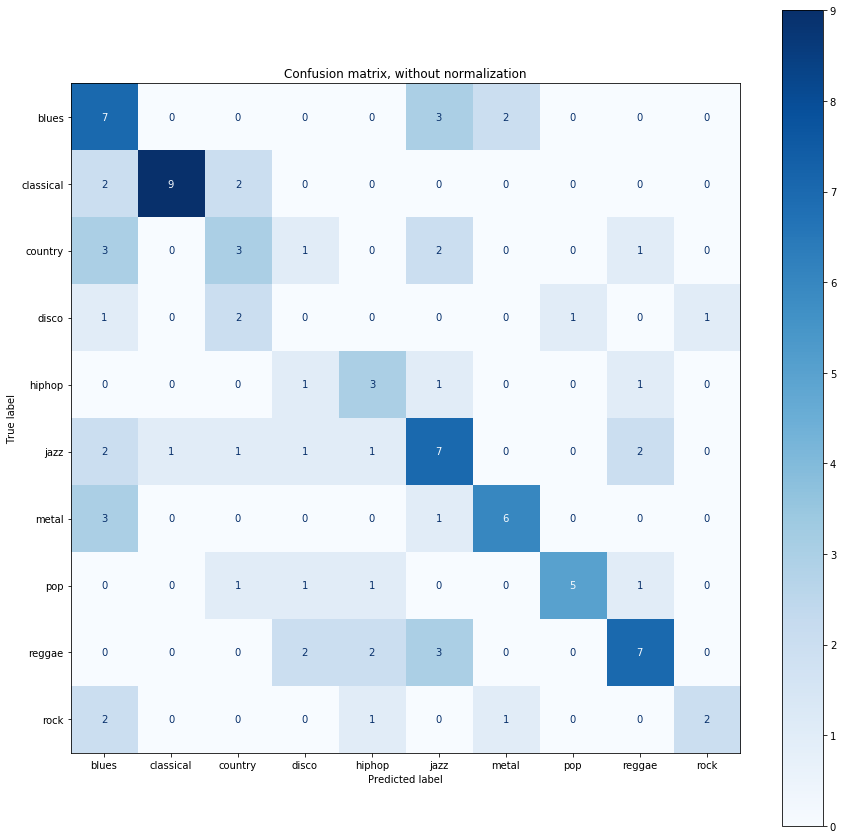

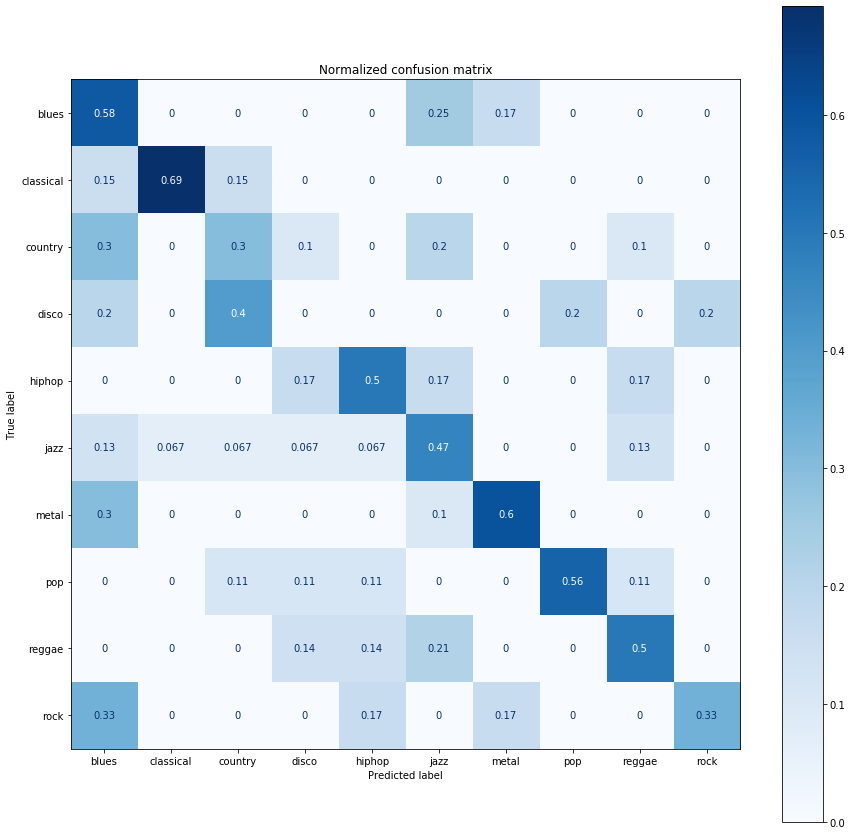

In [20]:
class_names = ['blues', 'classical', 'country', 'disco', 
               'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, X_test_reduced, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()

So the genres that were the easiest to classify were metal, pop, and classical. This makes sense becasue those genres have very distinct sounds.

In [31]:
y_prob = clf.predict_proba(X_test_reduced)

macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro)".format(macro_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.870138 (macro)
One-vs-Rest ROC AUC scores:
0.871591 (macro)
